# UMAPs Neurips samples, NK cells

In this notebook UMAPs are generated from latent space, CLR transformed protein counts and RNA expression to compare the clustering results. Leiden clusters are calculated for each object (latent, protein and RNA) and highly expressed genes/markers are searched using scanpy rank_genes_groups -function. Columns containing only zero-values were removed from RNA object. Mitochondrial and ribosomal genes are removed from analysis as well. 


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
import scvi
import scanpy as sc
import umap

from ridgeplot import ridgeplot
from pySankey import sankey

import warnings

warnings.filterwarnings('ignore')



# 1. Preparations

In [14]:
#Neurips

adata = sc.read_h5ad('/Users/tiinatuononen/Desktop/Thesis/Project/data/adata_neurips_norm_outer.h5ad')

adata

AnnData object with n_obs × n_vars = 80998 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [15]:
#Selecting only one sample
adata =adata[adata.obs['POOL'] == "s4d1"]

adata

View of AnnData object with n_obs × n_vars = 4885 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS'
    obsm: 'ADT_X_pca', 'ADT_X_umap', 'ADT_isotype_controls', 'GEX_X_pca', 'GEX_X_umap', 'X_pca', 'X_totalVI', 'X_umap', 'protein_expression', 'protein_expression_clr_neurips'
    layers: 'counts'

In [16]:
#protein information

adata_prot=adata.obsm['protein_expression_clr_neurips']

In [17]:
#some proteins and genes have same names, here _prot added after protein names

adata_prot=adata_prot.rename(columns={'CD2': 'CD2_prot', 'CX3CR1': 'CX3CR1_prot', 'CD226':'CD226_prot', 'TIGIT':'TIGIT_prot', 'CD27':'CD27_prot', 'CD38': 'CD38_prot','CD34': 'CD34_prot', 'CD224': 'CD224_prot', 'CD7': 'CD7_prot', 'CD44': 'CD44_prot', 'CD34': 'CD34_prot','CD5': 'CD5_prot'})

In [18]:
#adding protein information to obs

a = adata.obs
b = adata_prot

df=pd.concat([a, b], axis=1)
adata.obs=df

adata

AnnData object with n_obs × n_vars = 4885 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16', 'CD25',

Here 3. different objects from the same adata object are created; latent, protein and RNA. UMAP neigbors are calculated differently for each object (either using latent space, CLR normalized protein, or RNA expression data and then visualized using UMAP projection. 

In [19]:
#Neurips, latent

adata_neurips_latent = adata.copy()

#Neurips, proteins

adata_neurips_prot = adata.copy()

#Neurips, RNA

adata_neurips_rna = adata.copy()

In [20]:
#RNA data is added to obs 

adata_neurips_rna.obsm['adata_x'] = adata_neurips_rna.to_df()

adata_neurips_rna

AnnData object with n_obs × n_vars = 4885 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16', 'CD25',

In [21]:
#Both NK cell types selected + one sample is selected

sample_latent = adata_neurips_latent[(adata_neurips_latent.obs['cell_type'] == "NK") | (adata_neurips_latent.obs['cell_type'] == "NK CD158e1+")]

In [22]:
#Both NK cell types selected  + one sample is selected

sample_prot = adata_neurips_prot[(adata_neurips_prot.obs['cell_type'] == "NK") | (adata_neurips_prot.obs['cell_type'] == "NK CD158e1+")]

In [23]:
#Both NK cell types selected  + one sample is selected

sample_rna = adata_neurips_rna[(adata_neurips_rna.obs['cell_type'] == "NK") | (adata_neurips_rna.obs['cell_type'] == "NK CD158e1+")]

In [24]:
adata_latent = sample_latent
adata_gex = sample_rna
adata_adt = sample_prot

# Leiden clusters

In [25]:
#PCA for RNA and protein

sc.pp.pca(adata_gex)
sc.pp.pca(adata_adt)

In [26]:
adata_gex

AnnData object with n_obs × n_vars = 665 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16', 'CD25', 

In [27]:
#Calculating neighbors for UMAPs

sc.pp.neighbors(adata_latent, use_rep="X_totalVI")    
sc.pp.neighbors(adata_adt, use_rep = 'protein_expression_clr_neurips') 
sc.pp.neighbors(adata_gex) 

sc.tl.umap(adata_latent)
sc.tl.umap(adata_adt)
sc.tl.umap(adata_gex)

In [28]:
#Calculating leidens for latent object
sc.tl.leiden(adata_latent, resolution = 0.2, key_added = "leiden_0_2")
sc.tl.leiden(adata_latent, resolution = 0.4, key_added = "leiden_0_4")
sc.tl.leiden(adata_latent, resolution = 0.6, key_added = "leiden_0_6")

#calculating leidens for protein object
sc.tl.leiden(adata_adt, resolution = 0.2, key_added = "leiden_0_2")
sc.tl.leiden(adata_adt, resolution = 0.4, key_added = "leiden_0_4")
sc.tl.leiden(adata_adt, resolution = 0.7, key_added = "leiden_0_7")

#calculating leidens for RNA object
sc.tl.leiden(adata_gex, resolution = 0.4, key_added = "leiden_0_4")
sc.tl.leiden(adata_gex, resolution = 0.65, key_added = "leiden_0_65")
sc.tl.leiden(adata_gex, resolution = 0.7, key_added = "leiden_0_7")



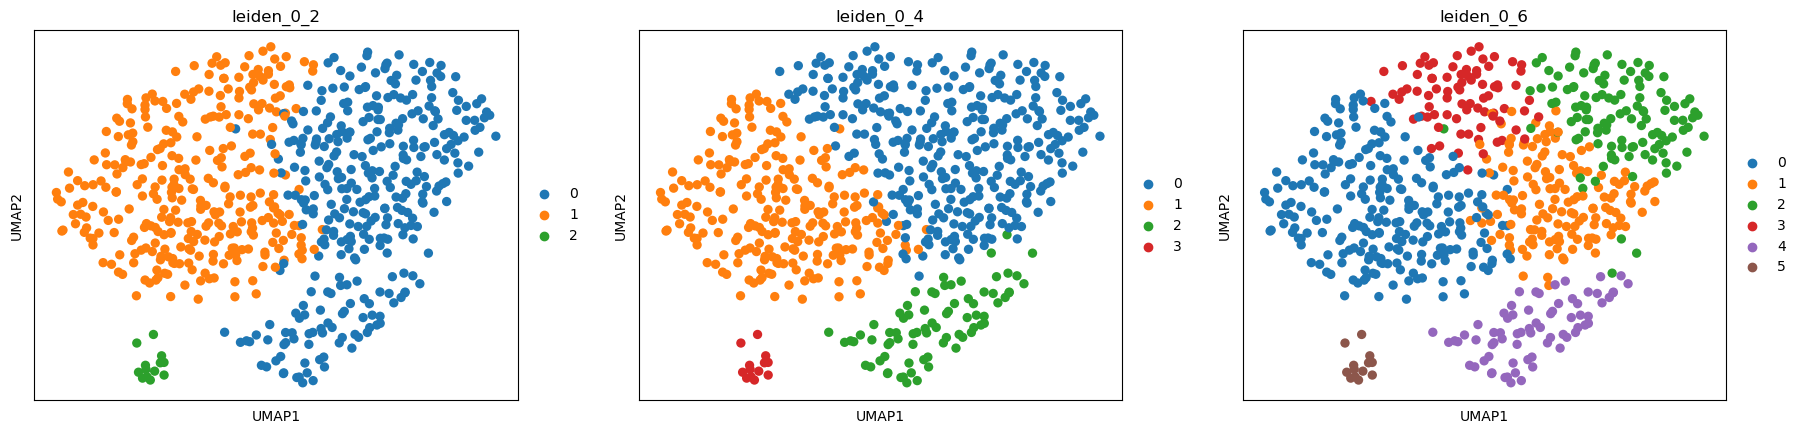

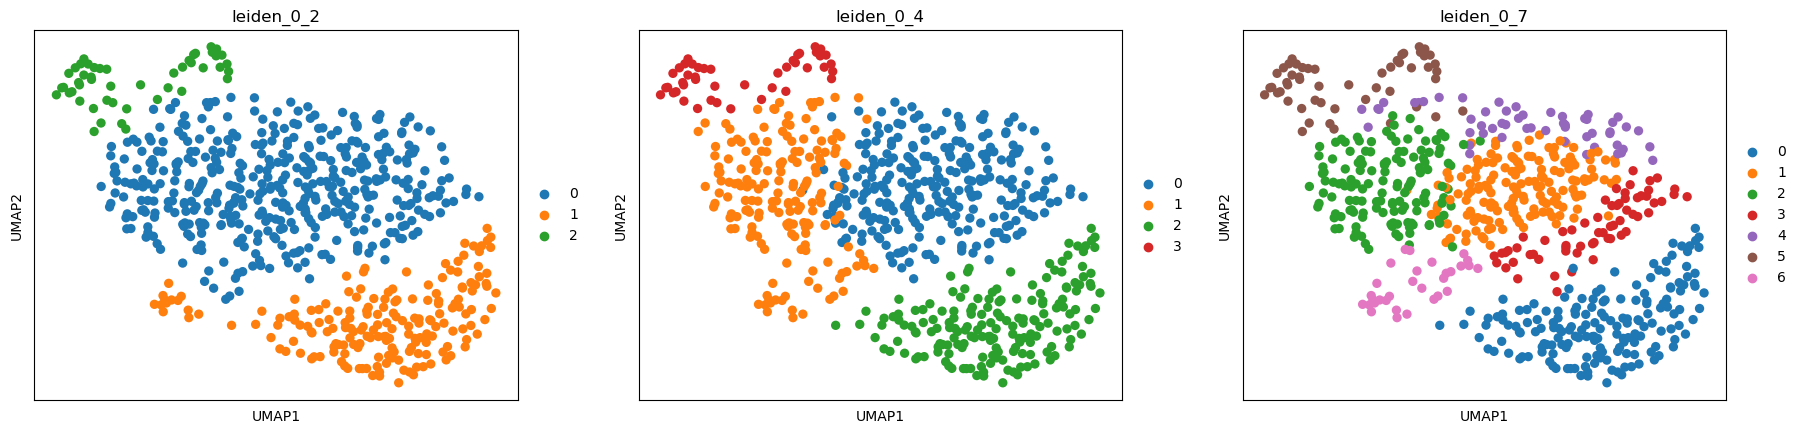

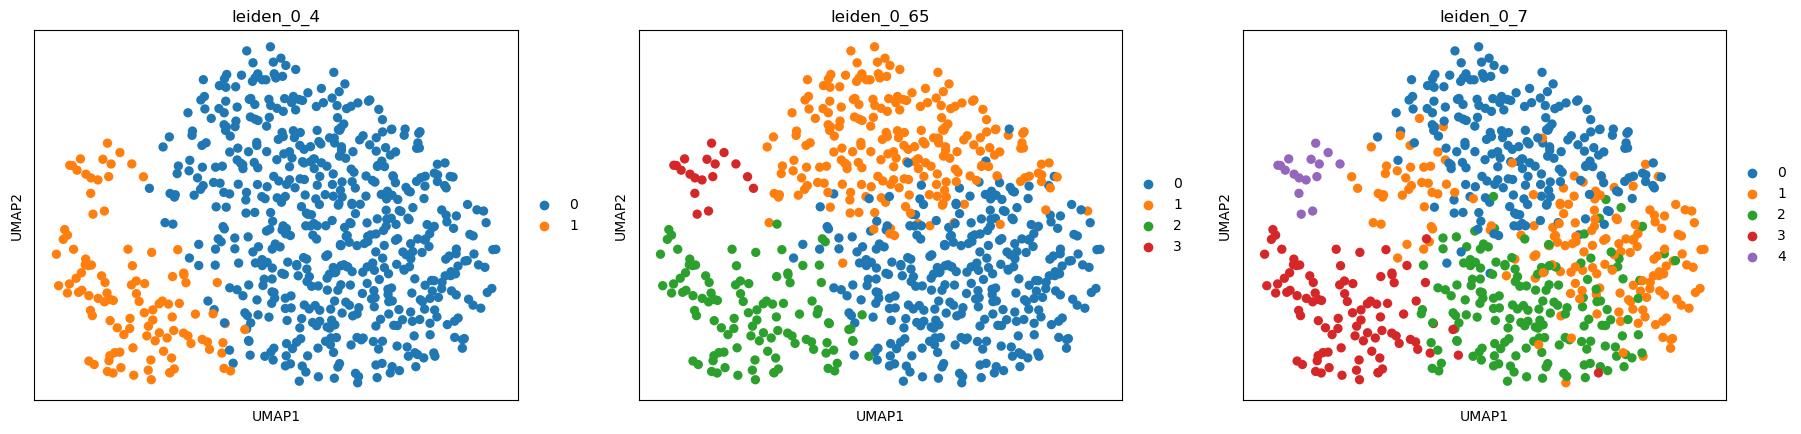

In [30]:
#Showing results in UMAPs


sc.pl.umap(adata_latent, color=['leiden_0_2', 'leiden_0_4', 'leiden_0_6'], ncols =3)
sc.pl.umap(adata_adt, color=['leiden_0_2', 'leiden_0_4', 'leiden_0_7'], ncols =3)
sc.pl.umap(adata_gex, color=['leiden_0_4', 'leiden_0_65', 'leiden_0_7'], ncols =3)

In [31]:
adata_latent

AnnData object with n_obs × n_vars = 665 × 21720
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16', 'CD25', 

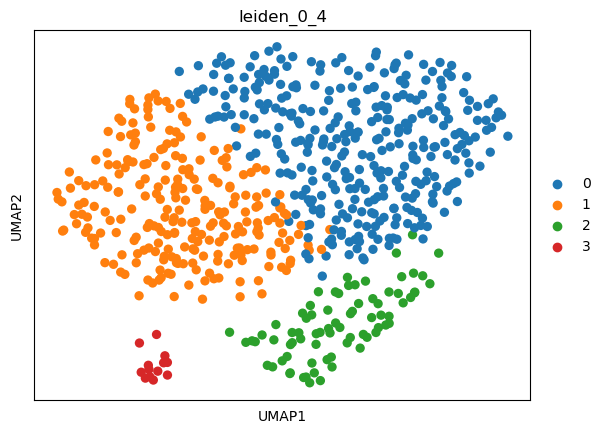

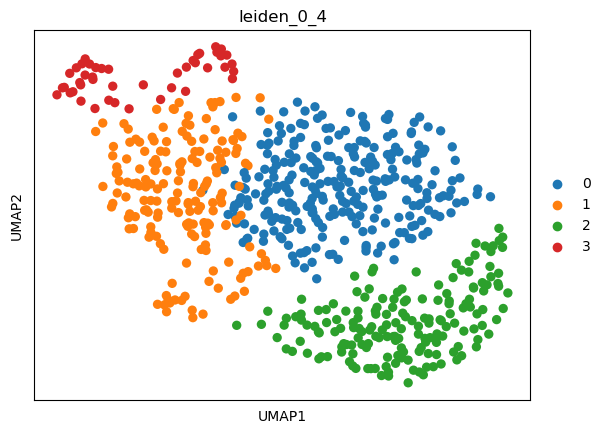

latent vs. protein


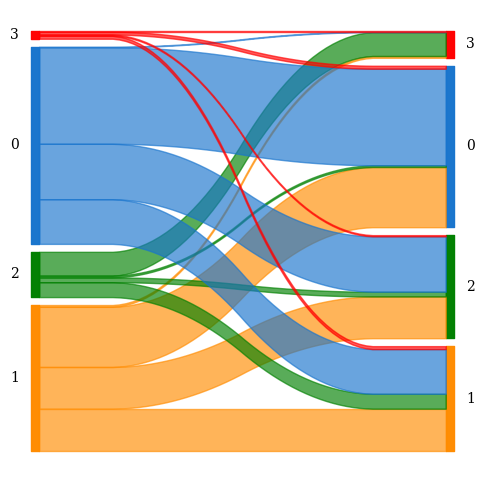

In [32]:
#Latent vs prot

sc.pl.umap(adata_latent, color=['leiden_0_4'])
sc.pl.umap(adata_adt, color=['leiden_0_4'])

print('latent vs. protein')

colors = {
    "0": "#1874CD",
    "1": "#FF8C00",
    "2": "Green",
    "3": "Red",
    #"4": "#AB82FF",
    #"5": "#8A360F"
}




sankey.sankey(adata_latent.obs.leiden_0_4, adata_adt.obs.leiden_0_4, colorDict=colors, aspect=20, fontsize=10)

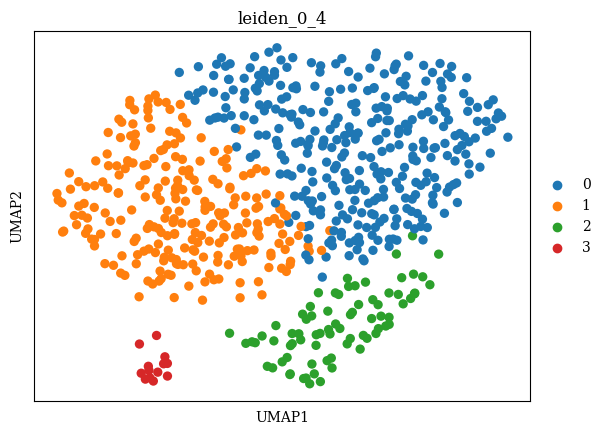

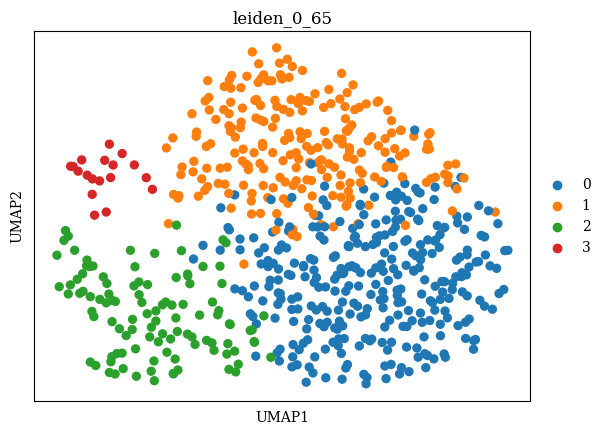

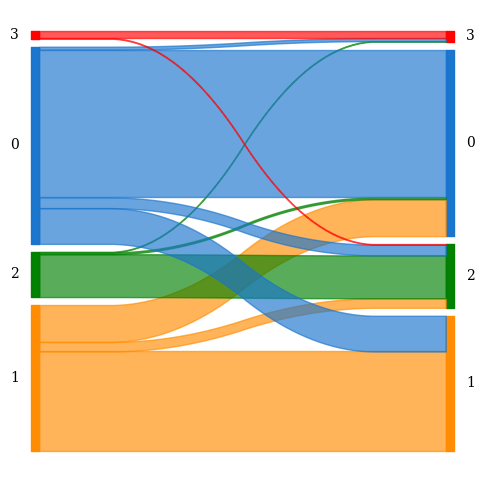

In [33]:
#Latent vs RNA

sc.pl.umap(adata_latent, color=['leiden_0_4'])
sc.pl.umap(adata_gex, color=['leiden_0_65'])
sankey.sankey(adata_latent.obs.leiden_0_4, adata_gex.obs.leiden_0_65, colorDict=colors, aspect=20, fontsize=10)

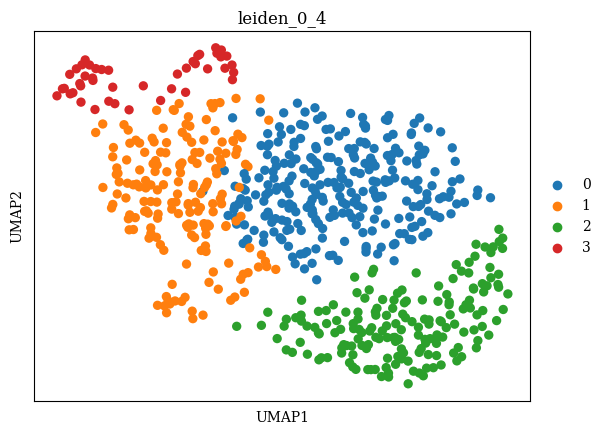

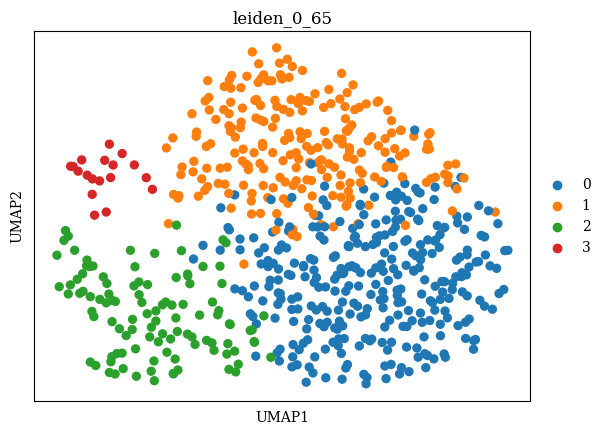

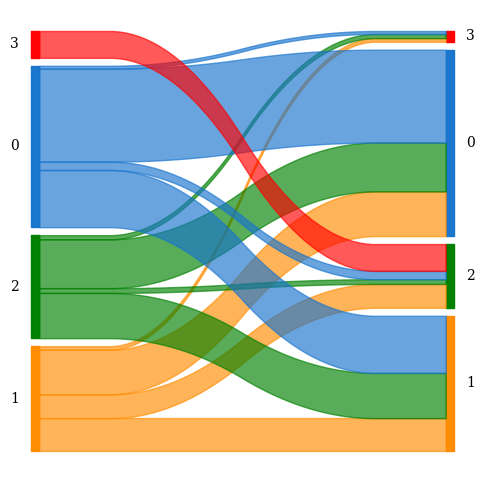

In [34]:
#prot vs rna
sc.pl.umap(adata_adt, color=['leiden_0_4'])
sc.pl.umap(adata_gex, color=['leiden_0_65'])
sankey.sankey(adata_adt.obs.leiden_0_4, adata_gex.obs.leiden_0_65, colorDict=colors, aspect=20, fontsize=10)

Latent


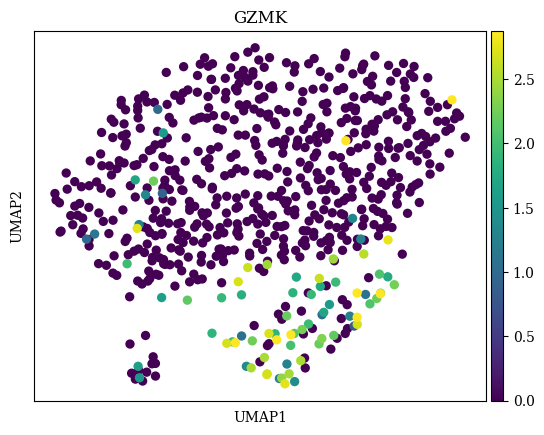

Protein


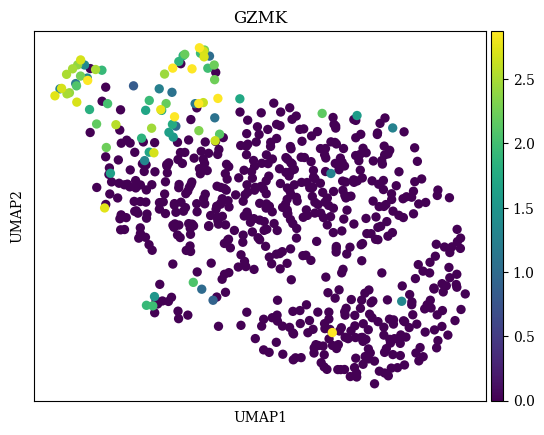

RNA


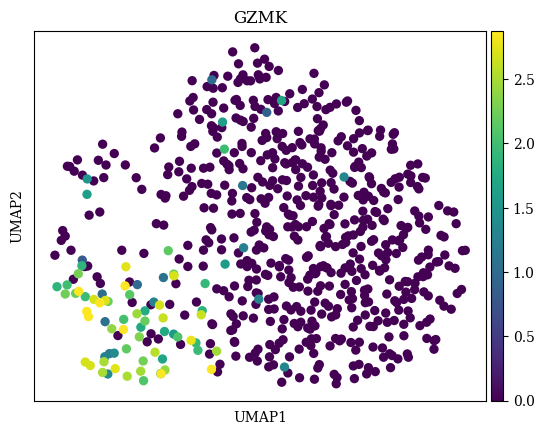

In [35]:
#Marker of immature cluster

print("Latent")
sc.pl.umap(adata_latent, color = ['GZMK'], vmax="p99", color_map = 'viridis', ncols = 3)
print("Protein")
sc.pl.umap(adata_adt, color = ['GZMK'], vmax="p99", color_map = 'viridis', ncols = 3)
print("RNA")
sc.pl.umap(adata_gex, color = ['GZMK'], vmax="p99", color_map = 'viridis', ncols = 3)




Latent


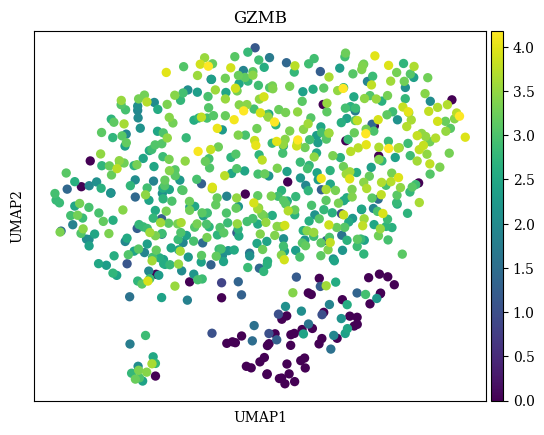

Protein


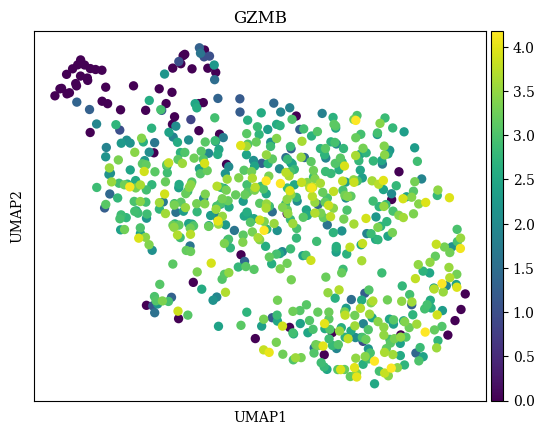

RNA


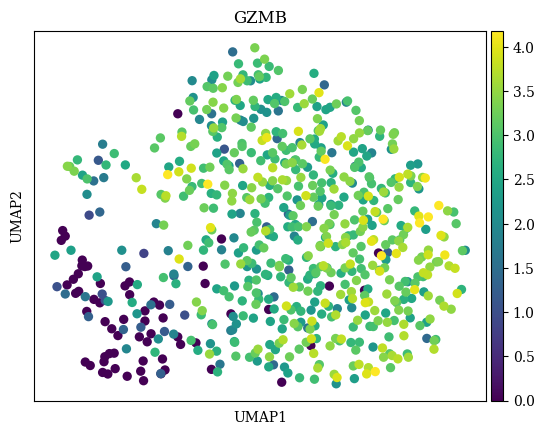

In [43]:
#Marker of mature NK cells

print("Latent")
sc.pl.umap(adata_latent, color = ['GZMB'], vmax="p99", color_map = 'viridis', ncols = 3)
print("Protein")
sc.pl.umap(adata_adt, color = ['GZMB'], vmax="p99", color_map = 'viridis', ncols = 3)
print("RNA")
sc.pl.umap(adata_gex, color = ['GZMB'], vmax="p99", color_map = 'viridis', ncols = 3)




Latent


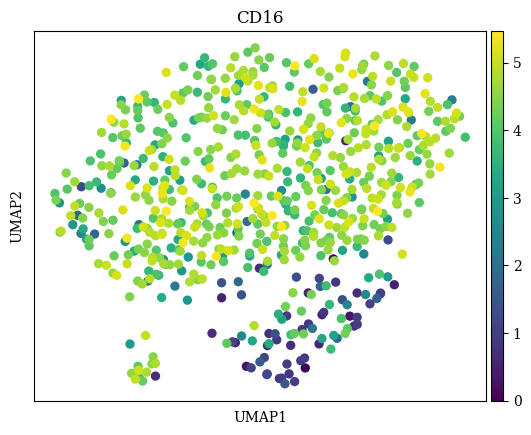

Protein


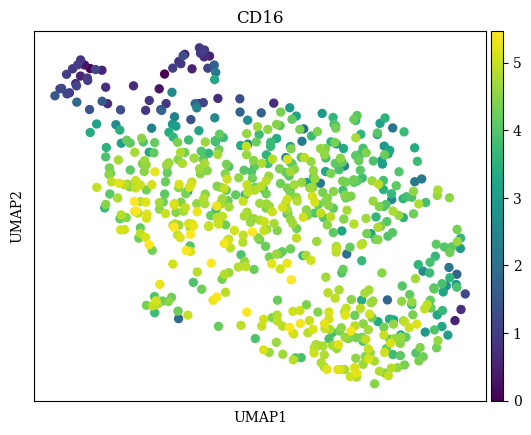

RNA


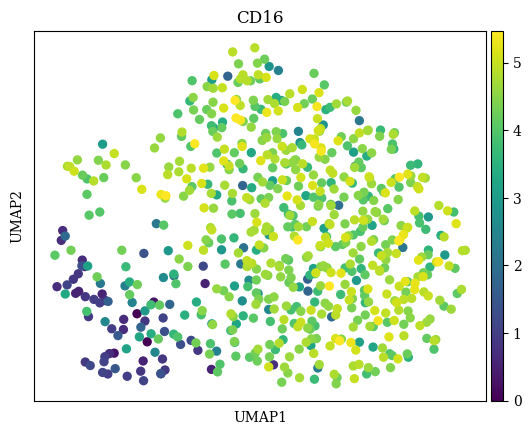

In [44]:

print("Latent")
sc.pl.umap(adata_latent, color = ['CD16'], vmax="p99", color_map = 'viridis', ncols = 3)
print("Protein")
sc.pl.umap(adata_adt, color = ['CD16'], vmax="p99", color_map = 'viridis', ncols = 3)
print("RNA")
sc.pl.umap(adata_gex, color = ['CD16'], vmax="p99", color_map = 'viridis', ncols = 3)



# Find marker genes/proteins from leiden clusters

In [ ]:
#Removing MALAT1 and mito + ribo genes from adata_gex

#MALAT1 is more or less technical finding => remove

#malat1 = adata_gex.var_names.str.startswith('MALAT1')

#genes to be removed
#mito_genes = adata_gex.var_names.str.startswith('MT-')
#ribo_genes = adata_gex.var_names.str.startswith('RPL')
#ribo_genes1 = adata_gex.var_names.str.startswith('RPS')

#remove = np.add(mito_genes, malat1)
#remove = np.add(remove, ribo_genes)
#remove = np.add(remove, ribo_genes1)

#other genes kept
#keep = np.invert(remove)

#adata_gex = adata_gex[:,keep]

#print(adata_gex.n_obs, adata_gex.n_vars)

In [36]:
#Removing mito + ribo genes from adata_latent


malat1 = adata_latent.var_names.str.startswith('MALAT1')

#genes to be removed
mito_genes = adata_latent.var_names.str.startswith('MT-')
ribo_genes = adata_latent.var_names.str.startswith('RPL')
ribo_genes1 = adata_latent.var_names.str.startswith('RPS')

remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, ribo_genes1)

#other genes kept
keep = np.invert(remove)

adata_latent = adata_latent[:,keep]

print(adata_latent.n_obs, adata_latent.n_vars)

665 21604


In [37]:
#Removing mito + ribo genes from adata_adt


malat1 = adata_adt.var_names.str.startswith('MALAT1')

#genes to be removed
mito_genes = adata_adt.var_names.str.startswith('MT-')
ribo_genes = adata_adt.var_names.str.startswith('RPL')
ribo_genes1 = adata_adt.var_names.str.startswith('RPS')

remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, ribo_genes1)

#other genes kept
keep = np.invert(remove)

adata_adt = adata_adt[:,keep]

print(adata_adt.n_obs, adata_adt.n_vars)

665 21604


In [38]:
#Removing mito + ribo genes from adata_gex


malat1 = adata_gex.var_names.str.startswith('MALAT1')

#genes to be removed
mito_genes = adata_gex.var_names.str.startswith('MT-')
ribo_genes = adata_gex.var_names.str.startswith('RPL')
ribo_genes1 = adata_gex.var_names.str.startswith('RPS')

remove = np.add(mito_genes, ribo_genes)
remove = np.add(remove, ribo_genes1)

#other genes kept
keep = np.invert(remove)

adata_gex = adata_gex[:,keep]

print(adata_gex.n_obs, adata_gex.n_vars)

665 21604


In [39]:
adata_gex

View of AnnData object with n_obs × n_vars = 665 × 21604
    obs: 'GEX_n_genes_by_counts', 'GEX_pct_counts_mt', 'GEX_size_factors', 'GEX_phase', 'ADT_n_antibodies_by_counts', 'ADT_total_counts', 'ADT_iso_count', 'cell_type', 'batch', 'ADT_pseudotime_order', 'GEX_pseudotime_order', 'Samplename', 'Site', 'DonorNumber', 'Modality', 'VendorLot', 'DonorID', 'DonorAge', 'DonorBMI', 'DonorBloodType', 'DonorRace', 'Ethnicity', 'DonorGender', 'QCMeds', 'DonorSmoker', 'is_train', 'n_genes', 'percent_mito', 'percent_ribo', 'n_counts', 'leiden_r2', 'leiden_r2_n_genes_MAD_diff', 'leiden_r2_n_counts_MAD_diff', 'leiden_r2_percent_mito_MAD_diff', 'filter', 'model_group', 'BATCH', 'POOL', 'SAMPLE_SET', 'SAMPLE_TYPE', 'SAMPLE_TISSUE', 'DIAGNOSIS', 'SUBTYPE', 'STATUS', 'CD86', 'CD274', 'CD270', 'CD155', 'CD112', 'CD47', 'CD48', 'CD40', 'CD154', 'CD52', 'CD3', 'CD8', 'CD56', 'CD19', 'CD33', 'CD11c', 'HLA-A-B-C', 'CD45RA', 'CD123', 'CD7_prot', 'CD105', 'CD49f', 'CD194', 'CD4', 'CD44_prot', 'CD14', 'CD16', 

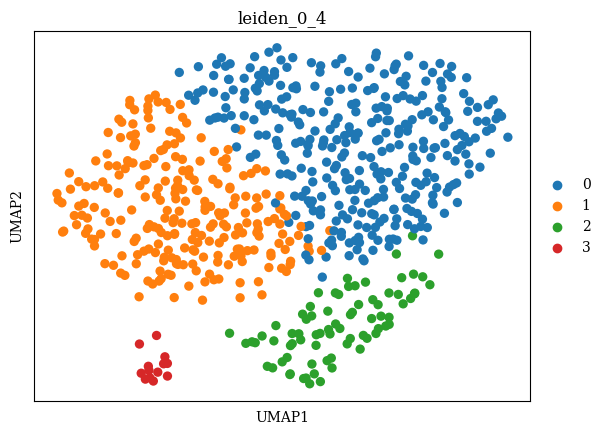

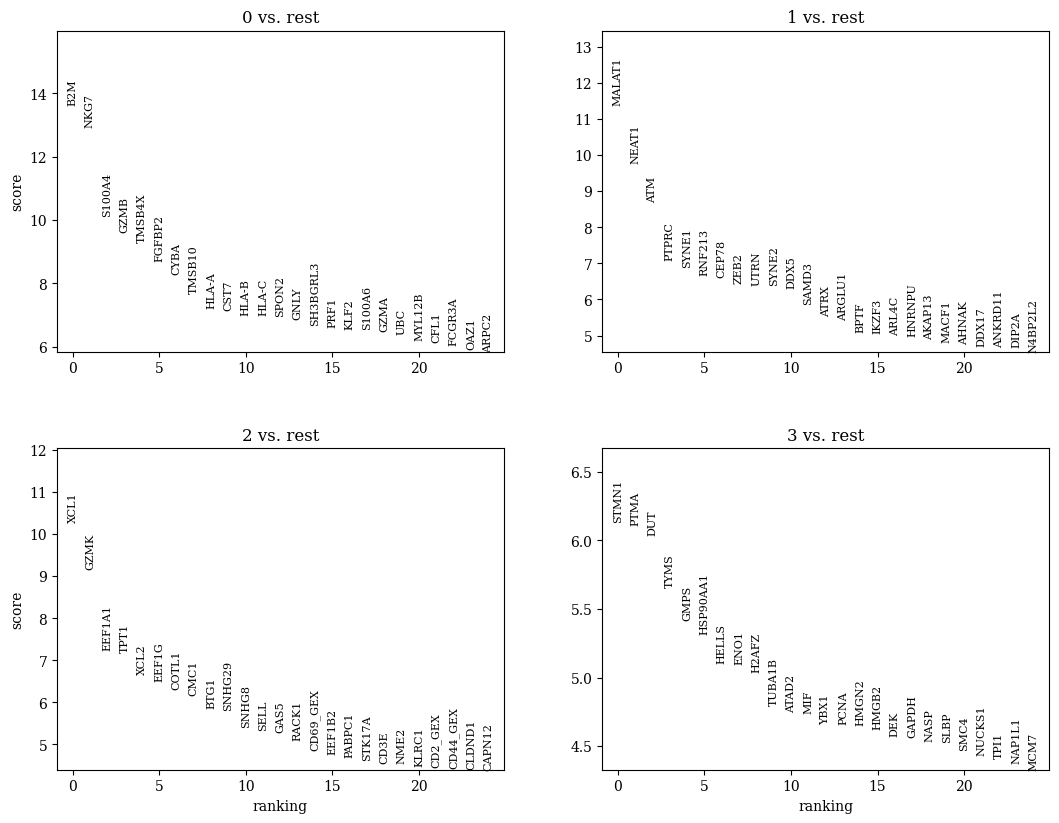

In [45]:
sc.pl.umap(adata_latent, color=['leiden_0_4'])
sc.tl.rank_genes_groups(adata_latent, 'leiden_0_4', method='wilcoxon')
sc.pl.rank_genes_groups(adata_latent, n_genes=25, sharey=False, ncols=2)

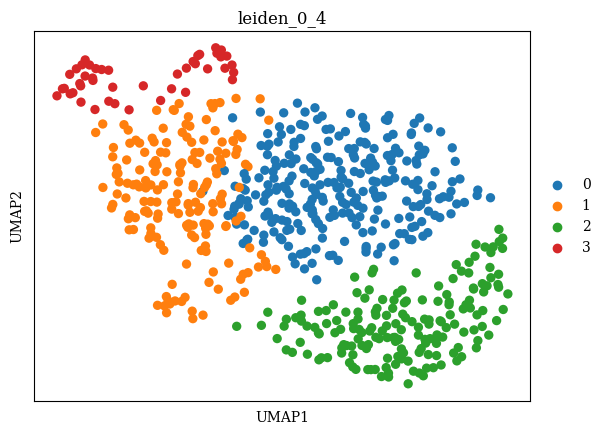

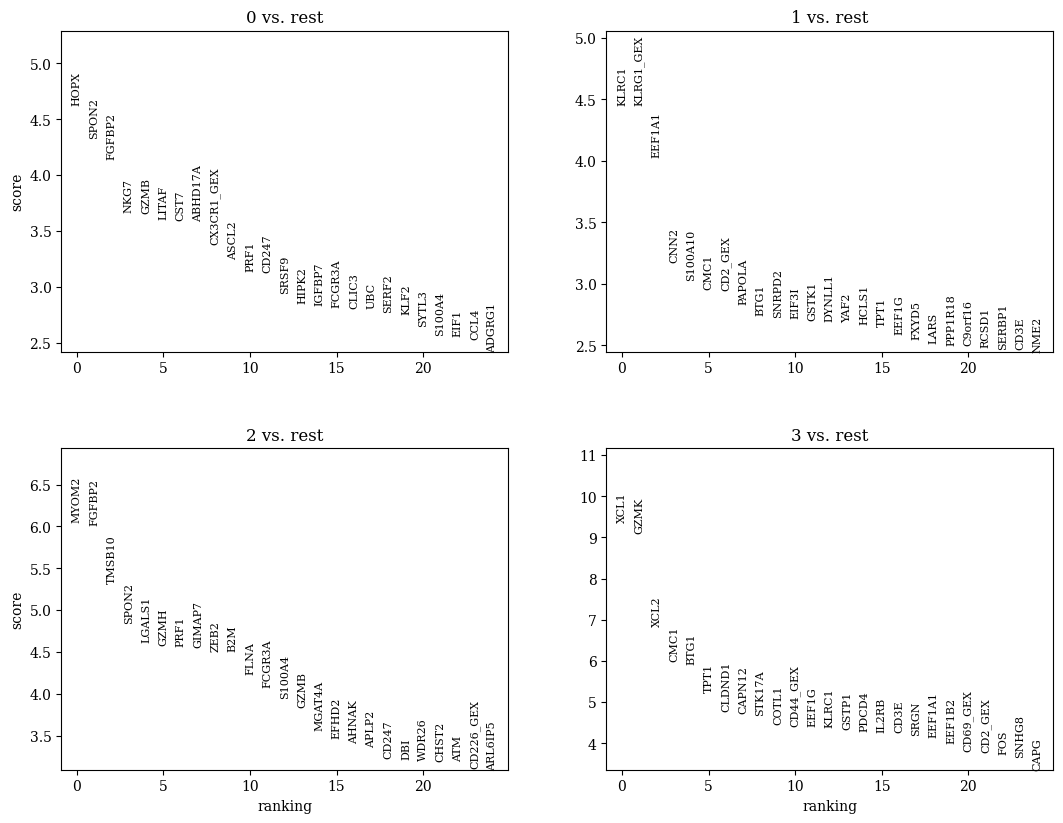

In [41]:

sc.pl.umap(adata_adt, color=['leiden_0_4'])
sc.tl.rank_genes_groups(adata_adt, 'leiden_0_4', method='wilcoxon')
sc.pl.rank_genes_groups(adata_adt, n_genes=25, sharey=False, ncols=2)

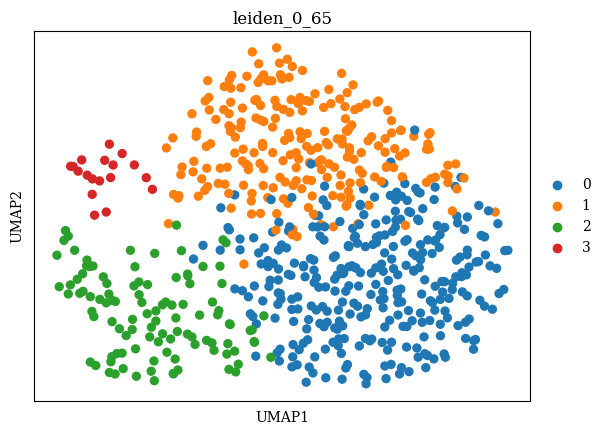

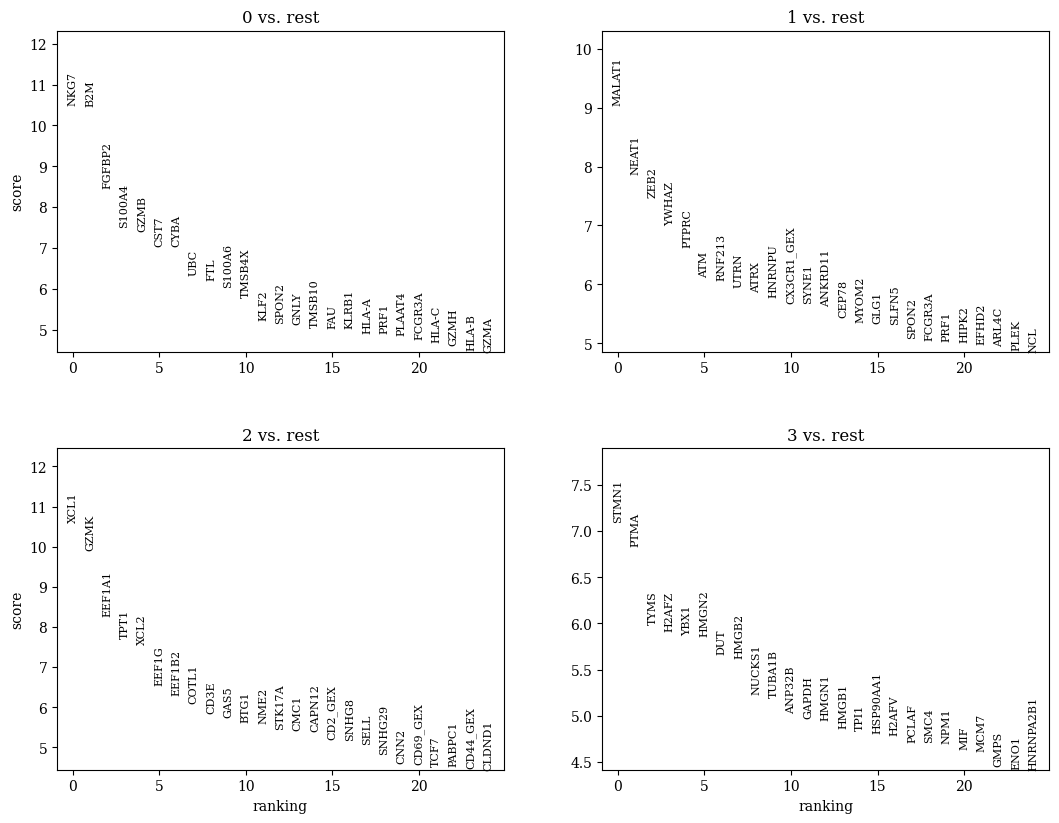

In [42]:

sc.pl.umap(adata_gex, color=['leiden_0_65'])
sc.tl.rank_genes_groups(adata_gex, 'leiden_0_65', method='wilcoxon')
sc.pl.rank_genes_groups(adata_gex, n_genes=25, sharey=False, ncols=2)